# 3D Nuclear Segmentation with RetinaNet

In [1]:
import os
import errno

import numpy as np

import deepcell

In [2]:
# Download the data (saves to ~/.keras/datasets)
filename = 'HEK293.trks'
test_size = 0.1 # % of data saved as test
seed = 0 # seed for random train-test split

(X_train, y_train), (X_test, y_test) = deepcell.datasets.tracked.hek293.load_tracked_data(
    filename, test_size=test_size, seed=seed)

print('X.shape: {}\ny.shape: {}'.format(X_train.shape, y_train.shape))

X.shape: (233, 30, 135, 160, 1)
y.shape: (233, 30, 135, 160, 1)


### Set up filepath constants

In [3]:
# the path to the data file is currently required for `train_model_()` functions

# NOTE: Change DATA_DIR if you are not using `deepcell.datasets`
DATA_DIR = os.path.expanduser(os.path.join('~', '.keras', 'datasets'))

DATA_FILE = os.path.join(DATA_DIR, filename)

# confirm the data file is available
assert os.path.isfile(DATA_FILE)

In [4]:
# Set up other required filepaths

# If the data file is in a subdirectory, mirror it in MODEL_DIR and LOG_DIR
PREFIX = os.path.relpath(os.path.dirname(DATA_FILE), DATA_DIR)

ROOT_DIR = '/data'  # TODO: Change this! Usually a mounted volume
MODEL_DIR = os.path.abspath(os.path.join(ROOT_DIR, 'models', PREFIX))
LOG_DIR = os.path.abspath(os.path.join(ROOT_DIR, 'logs', PREFIX))

# create directories if they do not exist
for d in (MODEL_DIR, LOG_DIR):
    try:
        os.makedirs(d)
    except OSError as exc:  # Guard against race condition
        if exc.errno != errno.EEXIST:
            raise

### Set up training parameters

In [5]:
from tensorflow.keras.optimizers import SGD, Adam
from deepcell.utils.train_utils import rate_scheduler

model_name = 'retinamovie_model'
backbone = 'resnet50'  # vgg16, vgg19, resnet50, densenet121, densenet169, densenet201

n_epoch = 40  # Number of training epochs
lr = 1e-5

optimizer = Adam(lr=lr, clipnorm=0.001)

lr_sched = rate_scheduler(lr=lr, decay=0.99)

batch_size = 8

num_classes = 1  # "object" is the only class

In [6]:
# Each head of the model uses its own loss
from deepcell.losses import RetinaNetLosses

sigma = 3.0
alpha = 0.25
gamma = 2.0
iou_threshold = 0.5
mask_size = (28, 28)

retinanet_losses = RetinaNetLosses(
    sigma=sigma,
    alpha=alpha,
    gamma=gamma,
    iou_threshold=iou_threshold,
    mask_size=mask_size)

loss = {
    'regression': retinanet_losses.regress_loss,
    'classification': retinanet_losses.classification_loss,
}

## Create the RetinaMovieMask Model

In [7]:
from deepcell.utils.retinanet_anchor_utils import generate_anchor_params

backbone_levels = ['C1', 'C2', 'C3', 'C4', 'C5']
pyramid_levels = ['P2', 'P3']
anchor_size_dict = {'P2': 16, 'P3': 32}

anchor_params = generate_anchor_params(pyramid_levels, anchor_size_dict)

fpb = 5  # number of frames in each training batch

In [8]:
from deepcell.model_zoo import RetinaNet

# Pass frames_per_batch > 1 to enable 3D mode!
model = RetinaNet(
    backbone=backbone,
    use_imagenet=False,
    panoptic=False,
    frames_per_batch=fpb,
    num_classes=num_classes,
    input_shape=X_train.shape[2:],
    backbone_levels=backbone_levels,
    pyramid_levels=pyramid_levels)

In [9]:
model.compile(loss=loss, optimizer=optimizer)

## Train the model

In [10]:
from deepcell.image_generators import RetinaMovieDataGenerator

datagen = RetinaMovieDataGenerator(
    rotation_range=180,
    zoom_range=(0.8, 1.2),
    horizontal_flip=True,
    vertical_flip=True)

datagen_val = RetinaMovieDataGenerator()

In [11]:
train_data = datagen.flow(
    {'X': X_train, 'y': y_train},
    batch_size=1,
    include_masks=False,
    include_final_detection_layer=False,
    frames_per_batch=fpb,
    pyramid_levels=pyramid_levels,
    anchor_params=anchor_params)

val_data = datagen_val.flow(
    {'X': X_test, 'y': y_test},
    batch_size=1,
    include_masks=False,
    include_final_detection_layer=False,
    frames_per_batch=fpb,
    pyramid_levels=pyramid_levels,
    anchor_params=anchor_params)

In [12]:
from tensorflow.keras import callbacks

model.fit_generator(
    train_data,
    steps_per_epoch=X_train.shape[0] // batch_size,
    epochs=n_epoch,
    validation_data=val_data,
    validation_steps=X_test.shape[0] // batch_size,
    callbacks=[
        callbacks.LearningRateScheduler(lr_sched),
        callbacks.ModelCheckpoint(
            os.path.join(MODEL_DIR, model_name + '.h5'),
            monitor='val_loss',
            verbose=1,
            save_best_only=True,
            save_weights_only=False)
    ])

Epoch 1/40
28/29 [===========================>..] - ETA: 1s - loss: 4.0572 - regression_loss: 2.9434 - classification_loss: 1.1137
Epoch 00001: val_loss improved from inf to 3.87098, saving model to /data/models/retinamovie_model.h5
29/29 [==============================] - 58s 2s/step - loss: 4.0522 - regression_loss: 2.9400 - classification_loss: 1.1122 - val_loss: 3.8710 - val_regression_loss: 2.8134 - val_classification_loss: 1.0576
Epoch 2/40
28/29 [===========================>..] - ETA: 0s - loss: 3.6972 - regression_loss: 2.7824 - classification_loss: 0.9148
Epoch 00002: val_loss improved from 3.87098 to 3.81954, saving model to /data/models/retinamovie_model.h5
29/29 [==============================] - 10s 330ms/step - loss: 3.6899 - regression_loss: 2.7779 - classification_loss: 0.9120 - val_loss: 3.8195 - val_regression_loss: 2.7056 - val_classification_loss: 1.1140
Epoch 3/40
28/29 [===========================>..] - ETA: 0s - loss: 3.3949 - regression_loss: 2.6709 - classifica

Epoch 20/40
28/29 [===========================>..] - ETA: 0s - loss: 2.4454 - regression_loss: 2.1314 - classification_loss: 0.3140
Epoch 00020: val_loss improved from 2.32286 to 2.14455, saving model to /data/models/retinamovie_model.h5
29/29 [==============================] - 9s 321ms/step - loss: 2.4408 - regression_loss: 2.1277 - classification_loss: 0.3130 - val_loss: 2.1446 - val_regression_loss: 1.8747 - val_classification_loss: 0.2699
Epoch 21/40
28/29 [===========================>..] - ETA: 0s - loss: 2.4368 - regression_loss: 2.1162 - classification_loss: 0.3206
Epoch 00021: val_loss did not improve from 2.14455
29/29 [==============================] - 7s 233ms/step - loss: 2.4324 - regression_loss: 2.1122 - classification_loss: 0.3201 - val_loss: 2.2345 - val_regression_loss: 1.9543 - val_classification_loss: 0.2802
Epoch 22/40
28/29 [===========================>..] - ETA: 0s - loss: 2.4261 - regression_loss: 2.1020 - classification_loss: 0.3241
Epoch 00022: val_loss did not

Epoch 40/40
28/29 [===========================>..] - ETA: 0s - loss: 1.9899 - regression_loss: 1.7536 - classification_loss: 0.2364
Epoch 00040: val_loss did not improve from 1.76156
29/29 [==============================] - 7s 235ms/step - loss: 1.9917 - regression_loss: 1.7556 - classification_loss: 0.2360 - val_loss: 1.7691 - val_regression_loss: 1.5833 - val_classification_loss: 0.1858


## Evaluate results

In [13]:
# Set up the prediction model
from deepcell.model_zoo import retinanet_bbox

prediction_model = retinanet_bbox(
    model,
    panoptic=False,
    frames_per_batch=fpb,
    max_detections=100,
    anchor_params=anchor_params)

prediction_model.load_weights(os.path.join(MODEL_DIR, model_name + '.h5'))

In [14]:
from deepcell.utils.retinanet_anchor_utils import evaluate

iou_threshold = 0.5
score_threshold = 0.01
max_detections = 100

average_precisions = evaluate(
    val_data,
    prediction_model,
    frames_per_batch=fpb,
    iou_threshold=iou_threshold,
    score_threshold=score_threshold,
    max_detections=max_detections,
)

# print evaluation
total_instances = []
precisions = []

for label, (average_precision, num_annotations) in average_precisions.items():
    print('{:.0f} instances of class'.format(num_annotations),
          label, 'with average precision: {:.4f}'.format(average_precision))
    total_instances.append(num_annotations)
    precisions.append(average_precision)

if sum(total_instances) == 0:
    print('No test instances found.')
else:
    print('mAP using the weighted average of precisions among classes: {:.4f}'.format(
        sum([a * b for a, b in zip(total_instances, precisions)]) / sum(total_instances)))
    print('mAP: {:.4f}'.format(sum(precisions) / sum(x > 0 for x in total_instances)))

374 instances of class 0 with average precision: 0.7656
mAP using the weighted average of precisions among classes: 0.7656
mAP: 0.7656


## Display results

Image Number: 5
Frame Number: 0


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


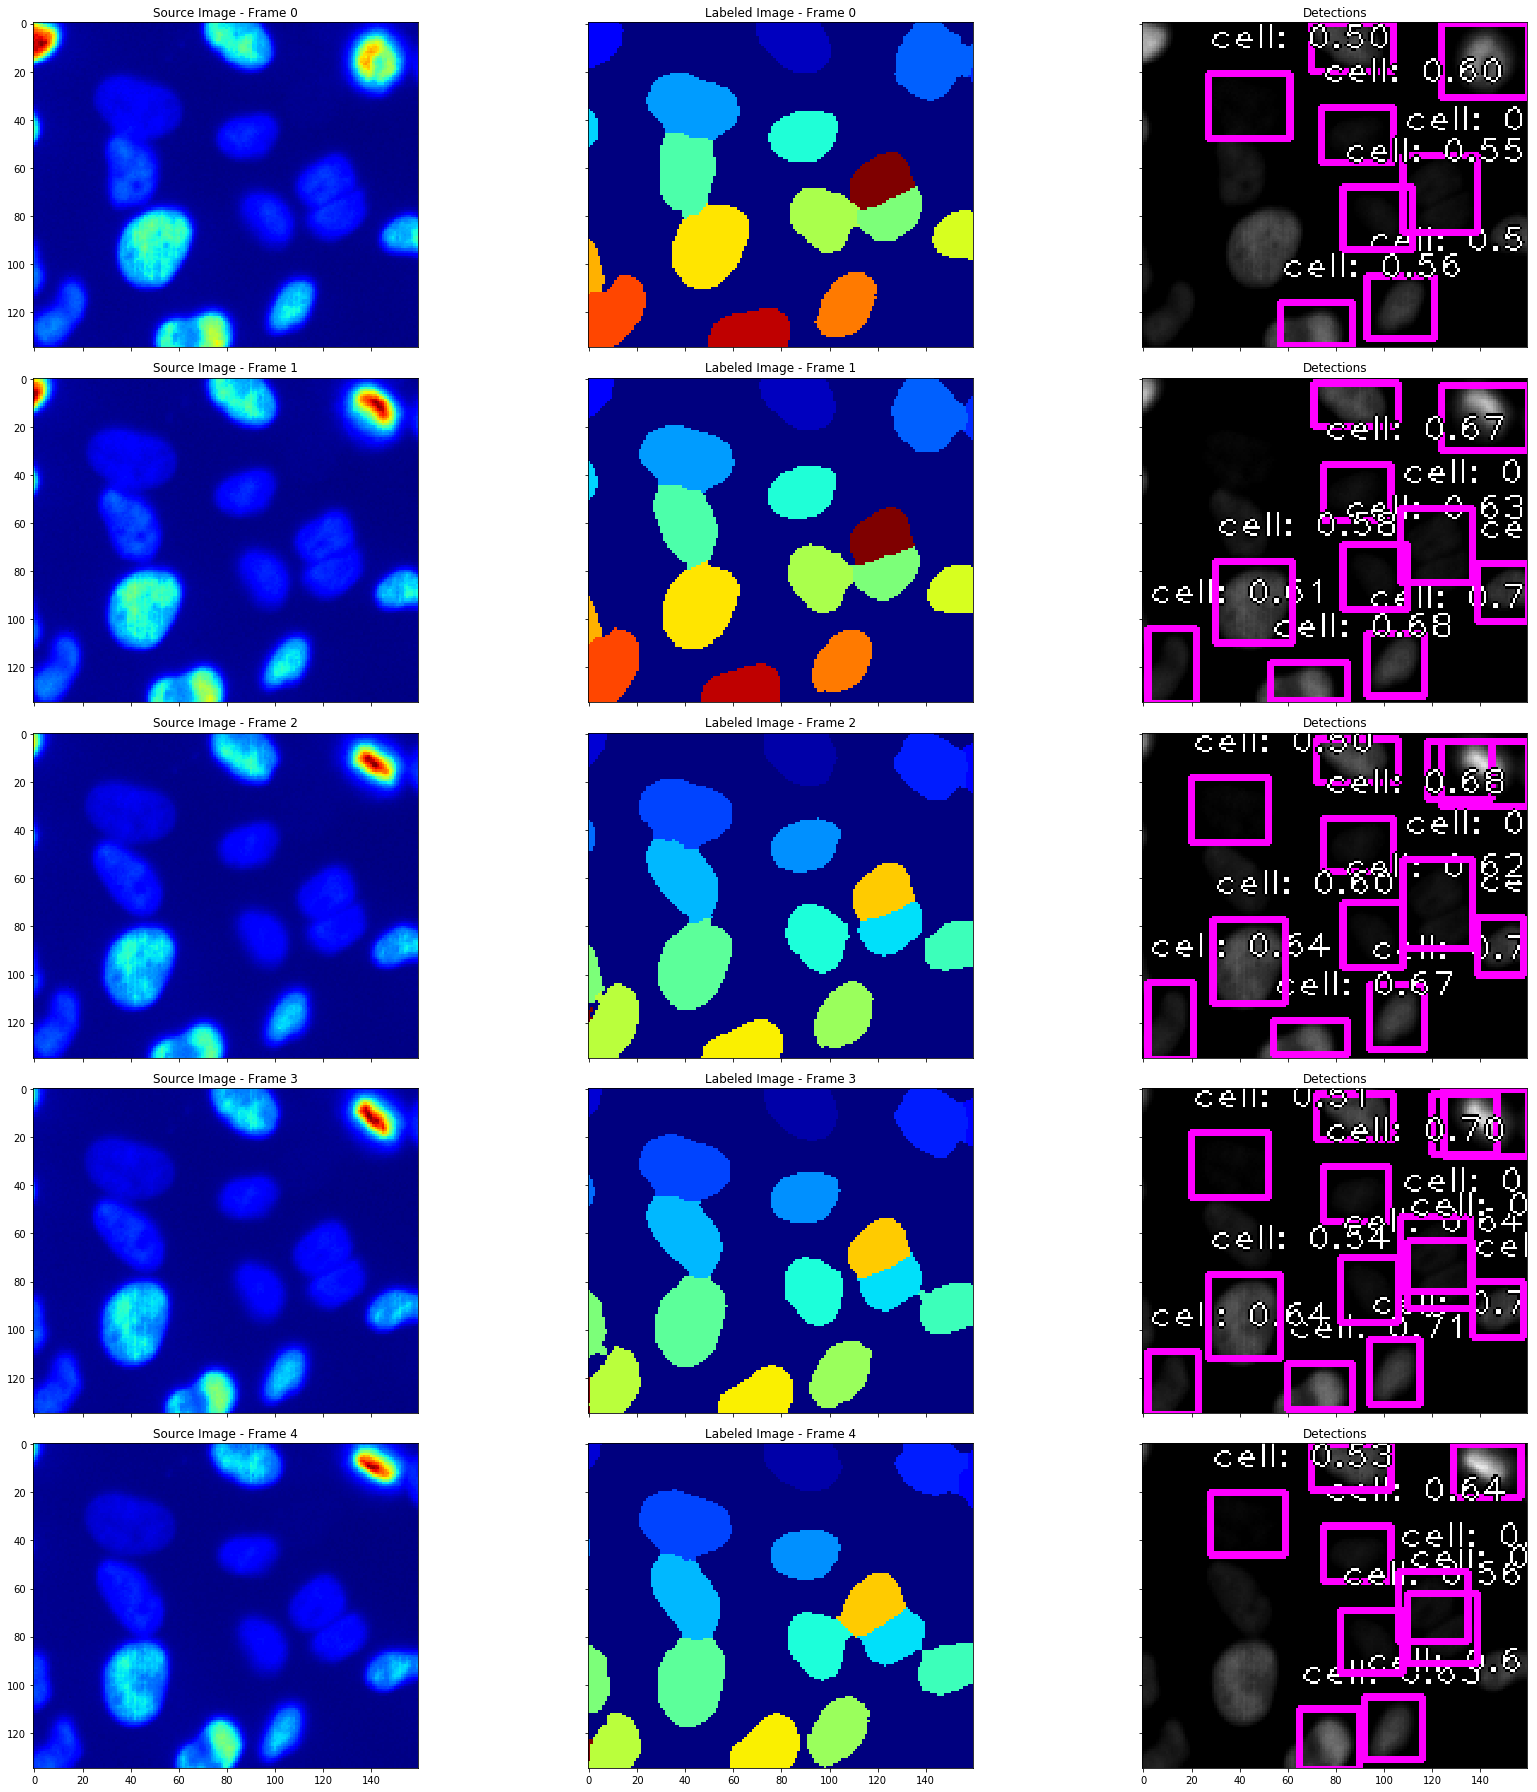

In [15]:
import matplotlib.pyplot as plt
import os
import time

import numpy as np

from deepcell.utils.plot_utils import draw_detections


index = np.random.randint(low=0, high=X_test.shape[0])
frame = np.random.randint(low=0, high=X_test.shape[1] - fpb)

print('Image Number:', index)
print('Frame Number:', frame)

image = X_test[index:index + 1, frame:frame + fpb]
mask = y_test[index:index + 1, frame:frame + fpb]

boxes, scores, labels = prediction_model.predict(image)
display = 0.01 * np.tile(np.expand_dims(image[0, ..., 0], axis=-1), (1, 1, 3))
mask = np.squeeze(mask)

draw_list = []

for i in range(fpb):
    draw = 0.1 * np.tile(image[0, i].copy(), (1, 1, 3))

    # draw detections
    deepcell.utils.plot_utils.draw_detections(
        draw, boxes[0, i], scores[0, i], labels[0, i],
        label_to_name=lambda x: 'cell', score_threshold=0.5)

    draw_list.append(draw)

fig, axes = plt.subplots(ncols=3, nrows=fpb, figsize=(25, 25), sharex=True, sharey=True)

for i in range(fpb):
    axes[i, 0].imshow(display[i, ..., 0], cmap='jet')
    axes[i, 0].set_title('Source Image - Frame {}'.format(frame + i))

    axes[i, 1].imshow(mask[i], cmap='jet')
    axes[i, 1].set_title('Labeled Image - Frame {}'.format(frame + i))

    axes[i, 2].imshow(draw_list[i], cmap='jet')
    axes[i, 2].set_title('Detections')

fig.tight_layout()
plt.show()